## Part I: Exploratory data analysis of the drug review dataset

#### We will get a general view of this data set using interactive plots by altair. Just like other projects, curiosity in the studied topic is the fundamental and presistent driving force of all data analysis.

Please use https://nbviewer.jupyter.org/ to open this notebook on github. Otherwise, the interactive plot by Altair will not show properly. 

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import pandas_profiling
import matplotlib.pyplot as plt
import altair as alt
import datetime

In [69]:
url='data/drugsComTest_raw.tsv'
test=pd.read_csv(url, sep="\t", index_col=0)
url2='data/drugsComTrain_raw.tsv'
train=pd.read_csv(url2, sep="\t", index_col=0)
df=pd.concat([test, train])

In [70]:
df.head(3)

,drugName,condition,review,rating,date,usefulCount
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3


In [71]:
df.shape

(215063, 6)

In [72]:
df.isna().sum()

drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

In [73]:
#remove samples with missing conditions
df_new=df.dropna(0, how='any')
df_new.shape

(213869, 6)

In [74]:
import pandas_profiling
pandas_profiling.ProfileReport(df_new)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1. date 

  **Qs:**
  
<span style='color:Blue'>Is there any trend for year, month or weekday when people tend to write drug review online?</span>  

In [75]:
import warnings
warnings.filterwarnings("ignore")
df_new.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'], dtype='object')

In [76]:
import datetime
df_new.date=pd.to_datetime(df_new.date)
df_new.date[:5]

163740   2012-02-28
206473   2009-05-17
159672   2017-09-29
39293    2017-03-05
97768    2015-10-22
Name: date, dtype: datetime64[ns]

In [77]:
#we can check the time_series distribution for drugs 
df_new['year']=df_new.date.dt.year
df_new['month']=df_new.date.dt.month
df_new['weekday']=df_new.date.dt.weekday

In [78]:
df_new.columns

Index(['drugName', 'condition', 'review', 'rating', 'date', 'usefulCount',
       'year', 'month', 'weekday'],
      dtype='object')

[Text(0.5, 0, 'year'), Text(0, 0.5, 'The review counts'), (2007.0, 2018.0)]

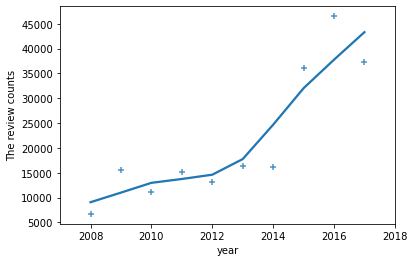

In [79]:
year_count=df_new.year.value_counts().sort_index()
ax=sns.regplot(y=year_count.sort_index(), x=year_count.index, lowess=True, marker="+")
ax.set(xlabel='year', ylabel='The review counts', xlim = (2007, 2018))

[Text(0.5, 0, 'month'), Text(0, 0.5, 'The review counts'), (0.0, 13.0)]

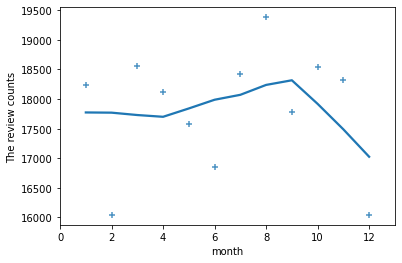

In [80]:
month_count=df_new.month.value_counts().sort_index()
ax=sns.regplot(y=month_count.sort_index(), x=month_count.index, lowess=True, marker="+")
ax.set(xlabel='month', ylabel='The review counts', xlim=(0, 13))

In [81]:
#seasonal change of review count from 2008 to 2017. We will evaluate both weekday and month patterns for the entire data and subset data for birth control
def month_year_count(df_new, y):
    r=df_new[df_new.year==y].month.value_counts()
    new=r.to_frame().reset_index()
    new.columns=['month','count']
    year=pd.Series([y,y,y,y,y,y,y,y,y,y,y,y]).T
    new['year']=year
    return new
month_year_count(df_new, 2015)

,month,count,year
0,10,3766,2015
1,12,3741,2015
2,8,3603,2015
3,9,3530,2015
4,11,3485,2015
5,7,3355,2015
6,5,2798,2015
7,4,2774,2015
8,6,2734,2015
9,3,2565,2015


In [82]:
month_year_count_df=pd.concat([month_year_count(df_new, y) for y in range(2008, 2018)], ignore_index=True)

In [83]:
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(month_year_count_df).mark_line(point=True).encode(
    x='month',
    y='count'
).transform_filter(
    click
)

hist = alt.Chart(month_year_count_df).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

In [84]:
#what if only for birth_control drugs. Can we detect any pattern?
df_bc = df_new[df_new.condition == 'Birth Control']
bc_month_year_count_df=pd.concat([month_year_count(df_bc, y) for y in range(2008, 2018)], ignore_index=True)
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(bc_month_year_count_df).mark_line(point=True).encode(
    x='month',
    y='count'
).transform_filter(
    click
)

hist = alt.Chart(bc_month_year_count_df).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

[Text(0.5, 0, 'weekday'), Text(0, 0.5, 'The review counts'), (-1.0, 7.0)]

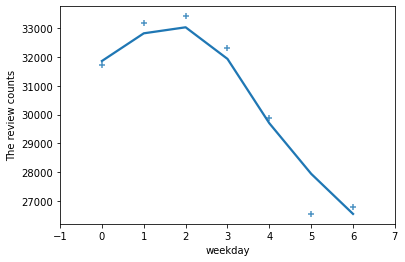

In [85]:
#How about weekday?
weekday_count=df_new.weekday.value_counts().sort_index()
ax=sns.regplot(y=weekday_count.sort_index(), x=weekday_count.index, lowess=True, marker="+")
ax.set(xlabel='weekday', ylabel='The review counts', xlim=(-1, 7))

In [86]:
def weekday_year_count(df_new, y):
    r=df_new[df_new.year==y].weekday.value_counts()
    new=r.to_frame().reset_index()
    new.columns=['weekday','count']
    year=pd.Series([y,y,y,y,y,y,y]).T
    new['year']=year
    return new
weekday_year_count(df_new, 2015)

,weekday,count,year
0,1,5668,2015
1,3,5667,2015
2,2,5446,2015
3,0,5211,2015
4,4,4905,2015
5,6,4630,2015
6,5,4572,2015


In [87]:
weekday_year_count_df=pd.concat([weekday_year_count(df_new, y) for y in range(2008, 2018)], ignore_index=True)
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(weekday_year_count_df).mark_line(point=True).encode(
    x='weekday',
    y='count'
).transform_filter(
    click
)

hist = alt.Chart(weekday_year_count_df).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

In [88]:
#what if only for birth_control drugs. Can we detect any pattern for weekday?
df_bc = df_new[df_new.condition == 'Birth Control']
bc_weekday_year_count_df=pd.concat([weekday_year_count(df_bc, y) for y in range(2008, 2018)], ignore_index=True)
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(bc_weekday_year_count_df).mark_line(point=True).encode(
    x='weekday',
    y='count'
).transform_filter(
    click
)

hist = alt.Chart(bc_weekday_year_count_df).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

<span style='color:Blue'>The amount of reviews has been greatly increased since 2015. People didn't write review in Dec that much as in the other months. As for weekday preference, Friday and Saturday were not the favorite time to write a drug review. </span>

### 2. condition

   **Qs:**
     <span style='color:Blue'>How many related conditions were mentioned in this data set? 
     What's the top conditions with most reviews? Is there any time dependent trend for condition?</span>

In [89]:
conditions=df_new.condition.unique().tolist()
len(conditions)

916

In [90]:
def top_con(y):
    r=df_new[df_new.year==y].condition.value_counts().head(10)
    new=r.to_frame().reset_index()
    new.columns=['condition','count']
    year=pd.Series([y, y, y, y, y, y, y, y, y, y]).T
    new['year']=year
    return new

In [91]:
top_con(2015)

,condition,count,year
0,Birth Control,7471,2015
1,Depression,1730,2015
2,Obesity,1486,2015
3,Acne,1443,2015
4,Anxiety,1195,2015
5,Weight Loss,922,2015
6,Insomnia,858,2015
7,Bipolar Disorde,854,2015
8,Emergency Contraception,784,2015
9,Abnormal Uterine Bleeding,778,2015


In [92]:
top_condition_year=pd.concat([top_con(y) for y in range(2008, 2018)], ignore_index=True)

In [93]:
#Check the change of top conditions during 2007 to 2017
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_condition_year).mark_bar().encode(
    x='count',
    y='condition'
).transform_filter(
    click
)

hist = alt.Chart(top_condition_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

In [94]:
#top_3_condition
top_3_con=df_new.condition.value_counts().head(3)
top_3_con.index

Index(['Birth Control', 'Depression', 'Pain'], dtype='object')

<span style='color:blue'>There are totally 916 conditions in this data set. Among them, birth control, depression and pain are the top 3 based on the total review counts between 2008 and 2017. In 2008, pain was the primary conditions in these reviews, but birth control and depression became the dominant ones from 2010 to 2017.</span>

### 3. drugName

   **Qs:**
 <span style='color:Blue'>How many drugs were included in this datset? Which drugs have most reviews? What are the top drugs with high ratings? Which drugs in the top condition categories have most reviews? Are there multiple drugs used for the same condition? Are there multiple conditions using the same drug?</span>
   
   #### 3.1 check drugs without differentiation of condition


In [95]:
drugs=df_new.drugName.unique().tolist()
len(drugs)

3667

In [96]:
#the top 20 drugs in this data set
drug_top_10_list=df_new.drugName.value_counts().head(10)
drug_top_10_list

Levonorgestrel                        4896
Etonogestrel                          4402
Ethinyl estradiol / norethindrone     3619
Nexplanon                             2892
Ethinyl estradiol / norgestimate      2682
Ethinyl estradiol / levonorgestrel    2400
Phentermine                           2077
Sertraline                            1859
Escitalopram                          1739
Mirena                                1673
Name: drugName, dtype: int64

Most of them are birth control drugs. Sertraline and Escitalopram are used for depression. Phentermine is used for weight loss.

In [97]:
drug_top_10=df_new[df_new.drugName.isin(drug_top_10_list.index)]
drug_top_10.shape

(28239, 9)

In [98]:
drug_top_10.groupby(['drugName','condition']).count().head(10)

review  rating  date  \
drugName     condition                                              
Escitalopram Anxiety                            669     669   669   
             Bipolar Disorde                     33      33    33   
             Body Dysmorphic Disorde              3       3     3   
             Borderline Personality Disorde       3       3     3   
             Depression                         515     515   515   
             Generalized Anxiety Disorde        392     392   392   
             Irritable Bowel Syndrome             8       8     8   
             Major Depressive Disorde            51      51    51   
             Not Listed / Othe                    5       5     5   
             Obsessive Compulsive Disorde        35      35    35   

                                             usefulCount  year  month  weekday  
drugName     condition                                                          
Escitalopram Anxiety                                 669   669    669      669  
             Bipolar Disorde                          33    33     33       33  
             Body Dysmorphic Disorde                   3     3      3        3  
             Borderline Personality Disorde            3     3      3        3  
             Depression                              515   515    515      515  
             Generalized Anxiety Disorde             392   392    392      392  
             Irritable Bowel Syndrome                  8     8      8        8  
             Major Depressive Disorde                 51    51     51       51  
             Not Listed / Othe                         5     5      5        5  
             Obsessive Compulsive Disorde             35    35     35       35

In [99]:
def top_drug(y):
    r=df_new[df_new.year==y].drugName.value_counts().head(10)
    new=r.to_frame().reset_index()
    new.columns=['drugName','count']
    year=pd.Series([y, y, y, y, y, y, y, y, y, y]).T
    new['year']=year
    return new
top_drug_year=pd.concat([top_drug(y) for y in range(2008, 2018)], ignore_index=True)

In [100]:
#Check the change of top 10 drugs during 2007 to 2017
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_drug_year).mark_bar().encode(
    x='count',
    y='drugName'
).transform_filter(
    click
)

hist = alt.Chart(top_condition_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

<span style='color:blue'>One drug can be used for multiple conditions. Between 2008 and 2017, the most reviewed drugs switched from pain killer as the top reviewed drugs to birth control pills as the dominant ones.</span>

#### 3.2 Check change of drug numbers in top 10 conditions from 2008 to 2017

In [101]:
condition_top_10=df_new.condition.value_counts().head(10)
condition_top_10_drug=df_new[df_new.condition.isin(condition_top_10.index)]
def top_condition_drug(y):
    r=condition_top_10_drug[condition_top_10_drug.year==y][['drugName', 'condition']].drop_duplicates().condition.value_counts()
    new=r.to_frame().reset_index()
    new.columns=['condition','drug_counts']
    year=pd.Series([y, y, y, y, y, y, y, y, y, y]).T
    new['year']=year
    return new
top_condition_drug_year=pd.concat([top_condition_drug(y) for y in range(2008, 2018)], ignore_index=True)

In [102]:
top_condition_drug_year

,condition,drug_counts,year
0,Pain,111,2008
1,Depression,50,2008
2,Birth Control,36,2008
3,Acne,36,2008
4,Anxiety,36,2008
...,...,...,...
95,Anxiety,45,2017
96,Bipolar Disorde,43,2017
97,ADHD,38,2017
98,Obesity,26,2017


In [103]:
#Check the change of drugs numbers for the top 10 conditions during 2007 to 2017
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_condition_drug_year).mark_bar().encode(
    x='drug_counts',
    y='condition'
).transform_filter(
    click
)

hist = alt.Chart(top_condition_drug_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

Pain relievers were the most reviewed drugs in 2008. After 2014, birth control drugs become the dominant one. 

#### 3.3 Check drug names within the same condition

In [104]:
condition_top_10_drug[['drugName', 'condition']].groupby(['condition','drugName']).sum().head(10)

Empty DataFrame
Columns: []
Index: [(ADHD, Adderall), (ADHD, Adderall XR), (ADHD, Adzenys XR-ODT), (ADHD, Amantadine), (ADHD, Amphetamine), (ADHD, Amphetamine / dextroamphetamine), (ADHD, Aptensio XR), (ADHD, Armodafinil), (ADHD, Atomoxetine), (ADHD, Budeprion XL)]

<span style='color:blue'>Similarly, one condition can be treated by different drugs. From the customers point of view, we choose drug based on conditions. </span>

### 4. rating

  **Qs:**
How is the rating distributed in this dataset across date? Which rating have the most reviews? Do drugs treated certain condition have highest rating? Is high rating revews necessarily associated with high usefulCounts? 

In [105]:
rating_dist=round(df_new.rating.value_counts(),2)
rating=rating_dist.to_frame().reset_index()
rating.columns=['rating', 'count']
rating

,rating,count
0,10.0,67682
1,9.0,36499
2,1.0,28769
3,8.0,24909
4,7.0,12470
5,5.0,10650
6,2.0,9203
7,3.0,8662
8,6.0,8403
9,4.0,6622


In [106]:
rating_dist_re=round(df_new.rating.value_counts(normalize=True),2)
rating_re=rating_dist_re.to_frame().reset_index()
rating_re.columns=['rating', 'relative_count']
rating_re

,rating,relative_count
0,10.0,0.32
1,9.0,0.17
2,1.0,0.13
3,8.0,0.12
4,7.0,0.06
5,5.0,0.05
6,2.0,0.04
7,3.0,0.04
8,6.0,0.04
9,4.0,0.03


<span style='color:blue'>Totally, the reviews with rating >= 9 are primary in this dataset, which account for ~50% of the original data set.  </span>

In [107]:
#check condition distribution across rating
def top_condition(y):
    r=df_new[df_new.rating==y].condition.value_counts().head(3)
    new=r.to_frame().reset_index()
    new.columns=['condition','count']
    rating=pd.Series([y,y,y,y,y,y,y,y,y,y]).T
    new['rating']=rating
    return new

In [108]:
top_condition(1)

,condition,count,rating
0,Birth Control,5876,1
1,Vaginal Yeast Infection,1417,1
2,Depression,1383,1


In [109]:
top_condition_rating=pd.concat([top_condition(y) for y in range(1, 11)], ignore_index=True)

In [110]:
#Check the change of top conditions across rating
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(top_condition_rating).mark_bar().encode(
    x='count',
    y='condition'
).transform_filter(
    click
)

hist = alt.Chart(top_condition_rating).mark_point().encode(
    y='rating:N',
    color=alt.condition(click, 'rating:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

<span style='color:blue'> birth control and depression are the top 2 condition regardless of the rating levels.</span>

In [111]:
#Let's check rating change with date
def rating_year(y):
    r=df_new[df_new.year==y].rating.value_counts().head(10)
    new=r.to_frame().reset_index()
    new.columns=['rating','count']
    year=pd.Series([y,y,y,y,y,y,y,y,y,y]).T
    new['year']=year
    return new

In [112]:
rating_year(2008)

,rating,count,year
0,10.0,3104,2008
1,9.0,1744,2008
2,8.0,1082,2008
3,7.0,388,2008
4,6.0,148,2008
5,5.0,99,2008
6,1.0,42,2008
7,4.0,41,2008
8,3.0,27,2008
9,2.0,25,2008


In [113]:
rating_count_year=pd.concat([rating_year(y) for y in range(2008, 2018)], ignore_index=True)
rating_count_year.head(20)

,rating,count,year
0,10.0,3104,2008
1,9.0,1744,2008
2,8.0,1082,2008
3,7.0,388,2008
4,6.0,148,2008
5,5.0,99,2008
6,1.0,42,2008
7,4.0,41,2008
8,3.0,27,2008
9,2.0,25,2008


In [114]:
#Check the change of rating across year
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(rating_count_year).mark_bar().encode(
    x='rating',
    y='count'
).transform_filter(
    click
)

hist = alt.Chart(rating_count_year).mark_point().encode(
    y='year:N',
    color=alt.condition(click, 'year:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter | hist

alt.HConcatChart(...)

<span style='color:blue'> The interesting thing is reviews with low ratings becomes the primary contributor as time goes on. Although there was very limited low-rating reviews in 2008, there were a lot in 2018. Are people becoming picky or the drug become less effective? </span>

### 5. usefulCount

In [115]:
usefulCount_dist=df_new.usefulCount.value_counts().to_frame().reset_index()
usefulCount_dist.columns=['usefulCount', 'counts']
alt.Chart(usefulCount_dist).mark_point().encode(
    x='usefulCount:Q',
    y='counts:Q',
    tooltip=('usefulCount', 'counts')
).interactive()

alt.Chart(...)

<span style='color:blue'>Most reviews have low usefulCounts less than 100. The highest usefulCounts is 730 and the lowest is 3 </span>

In [116]:
def usefulCount_rating(y):
    r=df_new[df_new.rating==y].usefulCount.value_counts()
    new=r.to_frame().reset_index()
    new.columns=['usefulCount','count']
    rating=pd.Series([y]*len(new)).T
    new['rating']=rating
    return new

In [117]:
usefulCount_count_rating=pd.concat([usefulCount_rating(y) for y in range(1, 11)], ignore_index=True)
usefulCount_count_rating.head(20)

,usefulCount,count,rating
0,2,1738,1
1,3,1664,1
2,1,1612,1
3,4,1608,1
4,0,1562,1
5,5,1518,1
6,6,1368,1
7,7,1239,1
8,8,1130,1
9,10,976,1


In [118]:
#Check the change of top conditions across rating
click = alt.selection_multi(encodings=['color'])

scatter = alt.Chart(usefulCount_count_rating).mark_point().encode(
    x='usefulCount',
    y='count',
    tooltip=('usefulCount', 'count')
).transform_filter(
    click
)

hist = alt.Chart(usefulCount_count_rating).mark_point().encode(
    y='rating:N',
    color=alt.condition(click, 'rating:N', alt.value('lightgray'), legend=None)
).add_selection(
    click
)

scatter.interactive() | hist

alt.HConcatChart(...)

<span style='color:blue'>Using this interactive plot, we can see reviews with high rating doesn't necessary have high usefulCount. Rating is given by the reviewer who used the drug. usefulCounts are determined by other reviewers except the one who write the review. A good resonable review should be a review with high usefulCount.</span>

### 6. review

We will explore EDA analysis for 'review' column individually in section 2.

In [119]:
df_new.to_csv('data/df_new.csv')